In [138]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.induction_pinn import PINN, numpy_to_tensor, train
from src.utils import get_data_and_feed
from typing import Optional, Union
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
from tqdm import tqdm 

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
def plot_feed(feeds):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(feeds['Time'], feeds['F'], width=feeds['Duration'], align='edge')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Feed (mL/h)')
    ax.set_title('Feed vs Time')
    plt.show()
    
def plot_simulation(t: Optional[list] = None, y: Optional[list] = None, full_df: Optional[pd.DataFrame] = None, train_df: Optional[pd.DataFrame] = None, net_df: Optional[pd.DataFrame] = None, title: Optional[str] = None):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 20))
    
    if t is not None and y is not None:
        ax1.plot(t, y[0], label='Biomass (ODE)', alpha=0.6)
        ax1.plot(t, y[1], label='Glucose (ODE)', alpha=0.6)
        ax2.plot(t, y[2], label='Protein (ODE)', alpha=0.6)
        ax3.plot(t, y[3], label='Volume (ODE)', alpha=0.6)
    
    if full_df is not None:
        ax1.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (EXP)', color='red', alpha=0.2)   
        ax1.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (EXP)', color='green', alpha=0.2)
        ax2.scatter(full_df['RTime'], full_df['Protein'], label='Protein (EXP)', color='blue', alpha=0.2)
        ax3.scatter(full_df['RTime'], full_df['V'], label='Volume (EXP)', color='purple', alpha=0.2)
    
    if train_df is not None:
        ax1.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (Train)', color='red', alpha=1)   
        ax1.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (Train)', color='green', alpha=1)
        ax2.scatter(train_df['RTime'], train_df['Protein'], label='Protein (Train)', color='blue', alpha=1)
        ax3.scatter(train_df['RTime'], train_df['V'], label='Volume (Train)', color='purple', alpha=1)
    
    if net_df is not None:
        ax1.scatter(net_df['RTime'], net_df['Glucose'], label='Glucose (Predicted)', marker='x', color='red', alpha=0.5)
        ax1.scatter(net_df['RTime'], net_df['Biomass'], label='Biomass (Predicted)', marker='x', color='green', alpha=0.5)
        ax2.scatter(net_df['RTime'], net_df['Protein'], label='Protein (Predicted)', marker='x', color='blue', alpha=0.5)
        ax3.scatter(net_df['RTime'], net_df['V'], label='Volume (Predicted)', marker='x', color='purple', alpha=0.5)

    ax1.set_xlabel("Time (hours)")
    ax1.set_ylabel("Concentration")
    ax1.legend(fontsize='small', markerscale=0.5)

    
    ax2.set_xlabel("Time (hours)")
    ax2.set_ylabel("Concentration")
    ax2.legend(fontsize='small', markerscale=0.5)

    ax3.set_xlabel("Time (hours)")
    ax3.set_ylabel("Volume")
    ax3.legend(fontsize='small', markerscale=0.5)
        
    plt.show()
 
def get_feed(feeds: pd.DataFrame, time: float) -> float:
    for _, row in feeds.iterrows():
        start_time = row["Time"]
        end_time = row["Time"] + row["Duration"]
        if start_time <= time < end_time:
            return row["F"] / 1000
    return 0

def simulate(df: pd.DataFrame, feeds: pd.DataFrame, \
             mu_max, Ks, Yxs, c1, c2, plot: bool = True):
    
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs
    Sin = 1.43 * 200

    def alpha(t):
        return c1 * (1 - np.exp(-c2 * t**2))

    def system_ode(t, y):
        X, S, P, V = y
        mu = mu_max * S / (Ks + S)
        F = get_feed(feeds, t)
        dXdt = mu * X + F * X / V
        dSdt = - mu * X / Yxs + F * (Sin - S) / V
        dPdt = alpha(t) * X - P * F / V
        dVdt = F
        return [dXdt, dSdt, dPdt, dVdt]
    
    t_start, t_end = df['RTime'].min(), df['RTime'].max()
    t_span = (t_start, t_end)
    y0 = [df['Biomass'].iloc[0], df['Glucose'].iloc[0], \
          df['Protein'].iloc[0], df['V'].iloc[0]]

    t_eval = np.linspace(t_start, t_end, 10000)
    sol = solve_ivp(system_ode, t_span=t_span, \
        y0=y0, t_eval=t_eval)
    
    if plot:
        plot_simulation(sol.t, sol.y, full_df=df)

    for i in range(sol.y.shape[0]):
        sol.y[i][sol.y[i] < 0] = 0

    return sol

def get_predictions_df(net: nn.Module, df: pd.DataFrame):
    net_df = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose'])
    t_test = df['RTime'].values
    t_test = numpy_to_tensor(t_test)
    net_df["RTime"] = df["RTime"].values
    net_df["Biomass"] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df["Glucose"] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    net_df["V"] = net.forward(t_test).detach().cpu().numpy()[:, 2]
    net_df["Protein"] = net.forward(t_test).detach().cpu().numpy()[:, 3]
    net_df.loc[net_df['Glucose'] < 0, 'Glucose'] = 0
    return net_df

def V(t: np.float32, F: np.float32, t_start: np.float32, V_0: np.float32) -> np.float32:
    ''' Linear volume increase '''
    return F/1000 * (t-t_start) + V_0

In [140]:
FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR04'

df, feeds = get_data_and_feed(FILENAME, EXPERIMENT)

# Only FED-BATCH-INDUCTION data
df = df[df['Process'] == 'FBI']
feeds = feeds[feeds['Induction']==1]

# Unique F for FBI
F = feeds['F'].values[0]

df['V'] = V(df['RTime'].values, F, df['RTime'].values[0], df['V'].values[0])

print(f'Dataset shape: {df.shape}')

Dataset shape: (6, 8)


In [141]:
def main(train_df: pd.DataFrame, full_df: pd.DataFrame, num_epochs: int = 2500):
    
    t_start, t_end = train_df['RTime'].min(), train_df['RTime'].max()

    t_train = numpy_to_tensor(train_df['RTime'].values)
    Biomass_train = numpy_to_tensor(train_df['Biomass'].values)
    Glucose_train = numpy_to_tensor(train_df['Glucose'].values)
    V_train = numpy_to_tensor(train_df['V'].values)
    Protein_train = numpy_to_tensor(train_df['Protein'].values)
    u_train = torch.cat((Biomass_train, Glucose_train, V_train, Protein_train), 1)

    net = PINN(input_dim=1, output_dim=4, t_start=t_start, t_end=t_end)

    net = train(net, t_train, u_train, train_df, feeds, \
                num_epochs=num_epochs, verbose=True)

    net_df = get_predictions_df(net, full_df)     

    sol = simulate(full_df, feeds, net.mu_max.item(), net.K_s.item(), net.Y_xs.item(), \
               c1=net.c1.item(), c2=net.c2.item(), plot=False)

    title = f'c1 = {net.c1.item():.4f}, c2 = {net.c2.item():.4f}'
    plot_simulation(full_df=full_df, train_df=train_df, net_df=net_df, t=sol.t, y=sol.y, title=title)
    
    return net, net_df

Running for 2 data points


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 1/2000 [00:00<04:48,  6.92it/s]

X_data_loss: 933.5703125
S_data_loss: 0.9435785412788391
V_data_loss: 156.52896118164062
P_data_loss: 0.16420215368270874
X_IC_loss: 908.8646850585938
S_IC_loss: 0.9007523655891418
V_IC_loss: 154.7408905029297
P_IC_loss: 0.12128977477550507
*** Positive V predictions
*** Max Biomass pred: 0.6296802163124084


 50%|█████     | 1001/2000 [04:19<03:39,  4.55it/s]

X_data_loss: 1.7358883619308472
S_data_loss: 0.0009141074260696769
V_data_loss: 0.47773969173431396
P_data_loss: 0.023485608398914337
X_IC_loss: 0.4171557128429413
S_IC_loss: 0.000493743980769068
V_IC_loss: 0.05635278671979904
P_IC_loss: 0.0304128248244524
*** Positive V predictions
*** Max Biomass pred: 33.33346176147461


100%|██████████| 2000/2000 [08:33<00:00,  3.90it/s]


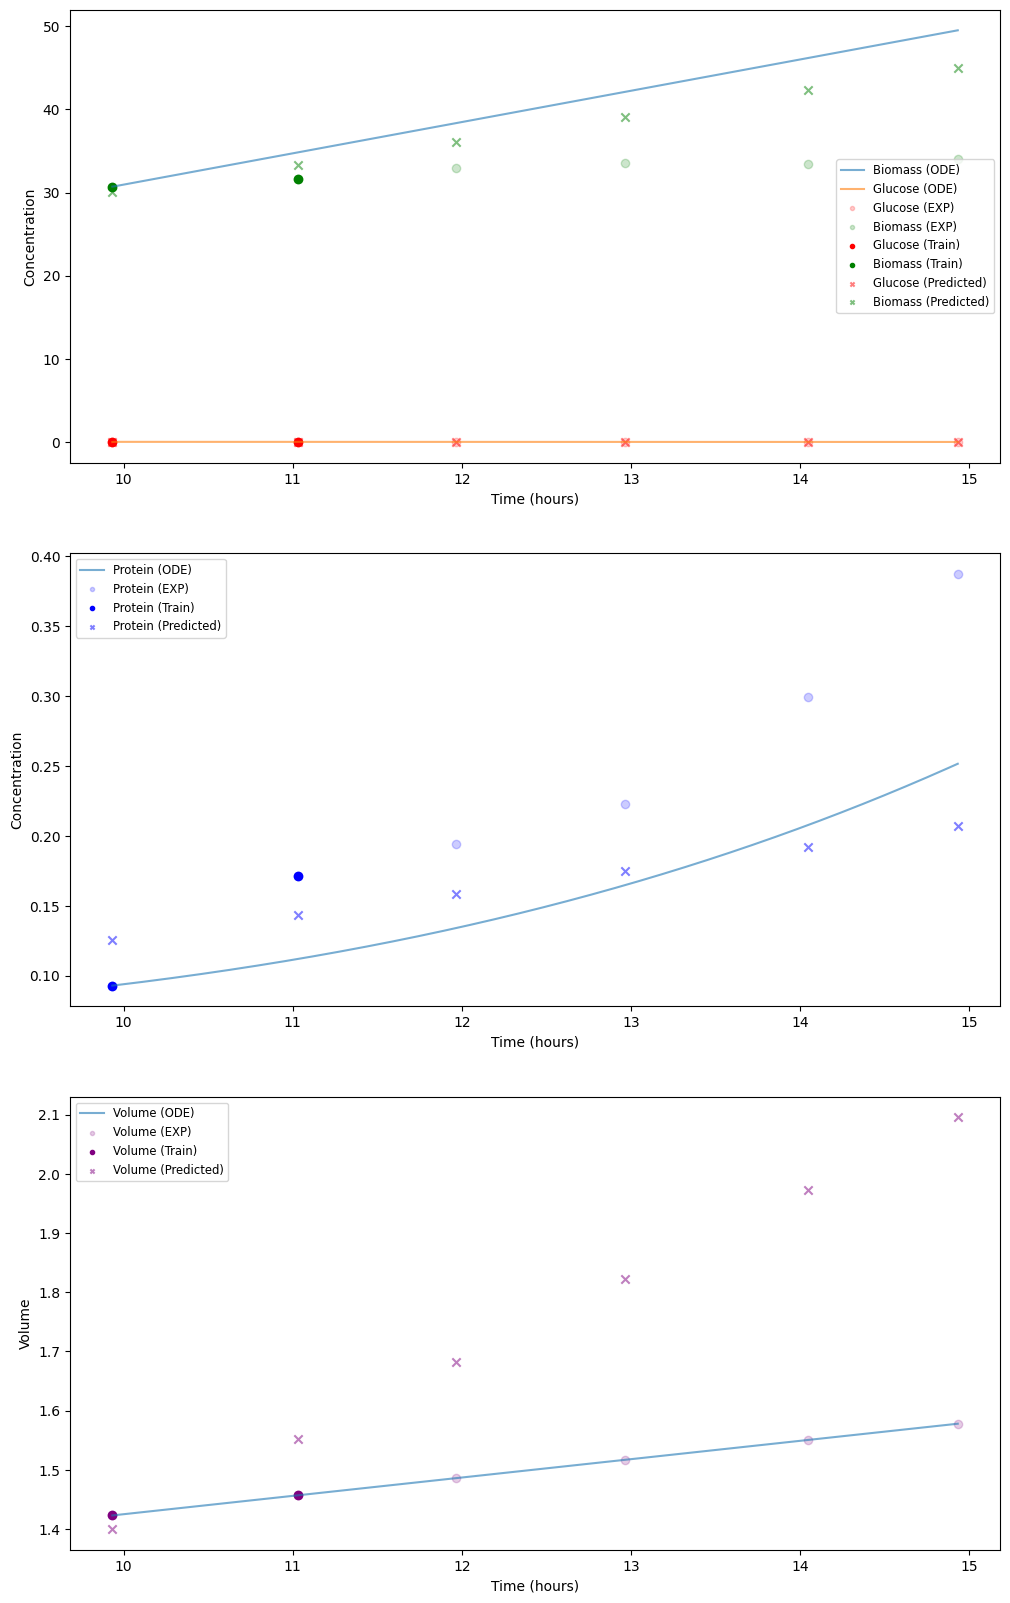

In [148]:
i = 2
print(f'Running for {i} data points')
train_df = df.iloc[:i]
net, net_df = main(train_df=train_df, full_df=df, num_epochs=2000)

In [145]:
print(f'c1={net.c1.item()}, c2={net.c2.item()}')

c1=0.04021858423948288, c2=0.00010688290058169514


In [146]:
net_df

,RTime,Biomass,Glucose,V,Protein
0,9.933333,27.698032,0.028004,1.284618,0.178970
1,11.033333,30.690306,0.024570,1.422713,0.203172
2,11.966667,33.229210,0.021658,1.539886,0.223706
3,12.966667,35.949471,0.018537,1.665428,0.245705
4,14.050000,38.896412,0.015156,1.801431,0.269539
5,14.933333,41.299294,0.012400,1.912327,0.288973
